In [1]:
import pandas as pd
import sys
sys.path
sys.path.append('../models')
import numpy as np
import pickle
import random
import os
import math
import sim_functions_cleaner  as sf
import operator
import study
import time as time_module

import TS_personal_params_pooled as pp
import TS_global_params_pooled as gtp
from numpy.random import uniform

#sys.path.append('../simulation')
import TS_fancy_pooled 
import TS
#import TS_fancy_pooled 
import eta
import pooling_bandits as pb
import warnings 
warnings.simplefilter('ignore')
from sklearn import preprocessing
#import tensorflow as tf
import gc
import standard_bandits as do_work
import feature_transformations as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
import logging
logging.getLogger("FFC").setLevel(logging.ERROR)

In [3]:
from pympler import muppy
all_objects = muppy.get_objects()
from pympler import summary


In [4]:
##for each person generate dates
##easiest to take from original data, this might best mimic actual situation 

In [5]:
#root =  '../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/processed/'

In [6]:
write_directory = '../temp'

In [7]:
def initialize_policy_params_TS(experiment,update_period,standardize=False):
    
    global_p =gtp.TS_global_params(21,baseline_keys=['tod','dow','pretreatment','location'],psi_features=[0,5], responsivity_keys= ['tod','dow','pretreatment','location'])
    personal_p = pp.TS_personal_params()
  
    
    global_p.standardize = standardize
    global_p.kdim =21

    #global_p.baseline_indices = [i for i in range(24)]

    global_p.psi_indices =[0,6]
    #[0,64]
    global_p.user_id_index =24
    #192
    #global_p.user_day_index =19
    #193
    
    #global_p.baseline_features = [i for i in range(192)]
    global_p.psi_features =[0,5]
    #[0,64]
    
    global_p.update_period = update_period
    initial_context = [0 for i in range(global_p.theta_dim)]
    
    global_p.mus0= global_p.get_mu0(initial_context)
    #global_p.get_mu0(initial_context)
    global_p.mus1= global_p.get_mu1(global_p.num_baseline_features)
    global_p.mus2= global_p.get_mu2(global_p.num_responsivity_features)
    #np.array([.120,3.3,-.11])
    #global_p.get_mu2(global_p.num_responsivity_features)
        
    #global_p.sigmas0= global_p.get_asigma(len( personal_p.mus0[person]))
    global_p.sigmas1= global_p.get_asigma(global_p.num_baseline_features+1)
    global_p.sigmas2= global_p.get_asigma( global_p.num_responsivity_features+1)
        
        
    
    #print(type(personal_p))
    
    for person in experiment.population.keys():
        experiment.population[person].root = '../../regal/murphy_lab/pooling/distributions/'
        

        
        personal_p.batch[person]=[[] for i in range(len(experiment.person_to_time[person]))]
        personal_p.batch_index[person]=0
        
        #personal_p.etas[person]=eta.eta()
        
        personal_p.last_update[person]=experiment.person_to_time[person][0]
        
        
    return global_p ,personal_p     

In [8]:
#days = pd.date_range(start = '7/22/2015',end =pd.Timestamp('7/22/2015')+pd.DateOffset(days=45),freq='30T')

In [9]:
#ft = experiment.study_days[96]

In [10]:
def get_optimal_reward(beta,states):
    return np.dot(beta,states)

In [11]:
def new_kind_of_simulation(experiment,policy=None,personal_policy_params=None,global_policy_params=None,generative_functions=None,which_gen=None,tf = None):
    #write_directory = '../../murphy_lab/lab/pooling/temp'
    experiment.last_update_day=experiment.study_days[0]
    tod_check = set([])
    
    
    additives = []
    
    for time in experiment.study_days:
        #if time>experiment.study_days[0]+pd.DateOffset(days=3):
            #break
        #if time> experiment.study_days[0]:
        #history  = pb.make_history(experiment)
        #time==experiment.last_update_day+pd.DateOffset(days=global_policy_params.update_period)
        if time==experiment.last_update_day+pd.DateOffset(days=global_policy_params.update_period):
            experiment.last_update_day=time
            
            #print('Global update', time,global_policy_params.decision_times, file=open('updates_{}_{}.txt'.format(len(experiment.population),global_policy_params.update_period), 'a'))
            if global_policy_params.decision_times>2 :
                global_policy_params.last_global_update_time=time
                #history =pb.make_history_new(.1,glob,experiment)
                #history = do_work.get_data_for_txt_effect_update_batch(experiment,global_policy_params)
                
                temp_hist = tf.get_history_decision_time_avail(experiment,time)
                
                #print('update')
                
                temp_hist= tf.history_semi_continuous(temp_hist,global_policy_params)
               
                    #sf.get_data_for_txt_effect_u
                    
                context,steps,probs,actions= tf.get_form_TS(temp_hist)
                #print(len(context))
                #print(len(steps))
                temp = TS.policy_update_ts_new( context,steps,probs,actions,global_policy_params.sigma,\
                                               global_policy_params.mus1,\
                                               global_policy_params.sigmas1,\
                                               global_policy_params.mus2,\
                                               global_policy_params.sigmas2,   
                                              )
                mu_beta = temp[0]
                Sigma_beta = temp[1]
                global_policy_params.update_mus(None,mu_beta,2)
                global_policy_params.update_sigmas(None,Sigma_beta,2)
                
        tod = sf.get_time_of_day(time)
        dow = sf.get_day_of_week(time)
        
        
 
        
        #if time==experiment.study_days[0]:
            #print('init weather')
            #weather = tf.get_weather_prior(tod,time.month,seed=experiment.rando_gen)
            #temperature = tf.continuous_temperature(weather)
        #elif time.hour in experiment.weather_update_hours and time.minute==0:
            #weather = tf.get_next_weather(str(tod),str(time.month),weather,seed=experiment.rando_gen)
            #temperature = tf.continuous_temperature(weather)
            ##location depends on person 
            
        for person in experiment.dates_to_people[time]:
                dt=False
                action = 0 
                prob=0
                #1
                ##for every active person update person specific aspects of their context
                participant = experiment.population[person]
                
                #update global context variables
                participant.set_tod(tod)
                participant.set_dow(dow)
                #participant.set_wea(weather)
                
            
                availability = (participant.rando_gen.uniform() < 0.8)
                #print(participant.pid)
                #print(availability)
                participant.set_available(availability)
                
                if time == participant.times[0]:
                    #get first location 
                    location = tf.get_location_prior(str(participant.gid),str(tod),str(dow),seed = participant.rando_gen)
                    participant.set_inaction_duration(0)
                    participant.set_action_duration(0)
                    #participant.set_duration(0)
                    #participant.set_dosage(0)
                    #personal_policy_params.etas[participant.pid]
                    
                    
                if time <= participant.times[0]:
                    steps_last_time_period = 0  
                    
                    ##set first pre-treatment, yesterday step count, variation and dosage
                else:
                    
                    if time.hour==0 and time.minute==0:
                        participant.current_day_counter=participant.current_day_counter+1
                    
                    #print(time)
                    steps_last_time_period = participant.steps
                
                 

                if time.hour in experiment.location_update_hours and time.minute==0:
                    location = tf.get_next_location(participant.gid,tod,dow,participant.get_loc(),seed =participant.rando_gen)
                
    
                
                participant.set_loc(location)
              
                

                prob = -1
                add=None
                optimal_action = -1
                optimal_reward = -100
                if time in participant.decision_times:
                     
                    
                    
                    dt=True
                    action=0
                    
                    if policy==None:
                        action = sf.get_action(policy)
                        
                        
                        
                    elif policy=='TS':
                        
                        
                        if 'pretreatment' in global_policy_params.baseline_keys:
                            to_call = sf.get_pretreatment(steps_last_time_period)
                        else:
                            to_call = steps_last_time_period
                        
                        ##want this to be a function
                        z=np.array([1,tod,dow,to_call,location])
                        prob = TS.prob_cal_ts(z,0,global_policy_params.mus2,global_policy_params.sigmas2,global_policy_params,seed = experiment.algo_rando_gen)
                        #if participant.pid==1:
                            
                            #print('prob _ {}'.format(prob))
                            #print(type(prob))
                        
                        action = int(experiment.algo_rando_gen.uniform() < prob)
                        
                    
                    
                    if availability:
                    

                   
                        tod_check.add(tod)
                    
                   
                    
                        context = [action,participant.gid,tod,dow,sf.get_pretreatment(steps_last_time_period),location,\
                              0,0,0]
                    
                        #participant.steps_last_time_period = participant.steps
                        #print(sf.get_pretreatment(participant.steps))
                        
                        steps = tf.get_steps_action(context,seed = participant.rando_gen)
                       
                        #add = sf.get_add_two(action,z,experiment.beta,participant.Z)
                        add = action*(sf.get_add_no_action(z,experiment.beta,participant.Z))
                        additives.append([action,add,prob])
                        participant.steps = steps+add
                        
                        ##calculate optimal
                        optimal_reward = get_optimal_reward(experiment.beta,z)
                        optimal_action = int(optimal_reward>=0)
                        
                    else:
                        #participant.steps_last_time_period = participant.steps
                        steps = tf.get_steps_no_action(participant.gid,tod,dow,location,sf.get_pretreatment(steps_last_time_period),seed = participant.rando_gen)
                        participant.steps = steps

                

                    global_policy_params.decision_times =   global_policy_params.decision_times+1
                
                    
                    
                else:
                    #participant.steps_last_time_period = participant.steps
                        steps = tf.get_steps_no_action(participant.gid,tod,dow,location,sf.get_pretreatment(steps_last_time_period),seed = participant.rando_gen)
                        participant.steps = steps     
                
                ##history:
                context_dict =  {'steps':participant.steps,'add':add,'action':action,'location':location,'location_1':int(location==1),\
                    'ltps':steps_last_time_period,'location_2':int(location==2),'location_3':int(location==3),\
                        'study_day':participant.current_day_counter,\
                                 'decision_time':dt,\
                                 'time':time,'avail':availability,'prob':prob,\
                                 'dow':dow,'tod':tod,\
                                 'pretreatment':sf.get_pretreatment(steps_last_time_period),\
                                'optimal_reward':optimal_reward,'optimal_action':optimal_action}
                participant.history[time]=context_dict


                #if global_policy_params.decision_times%100==0:
                   # my_directory = '{}/pop_size_{}_update_{}_study_length_{}/participant_{}'.format(global_policy_params.write_directory,participant.pid,experiment.study_length,len(experiment.population),global_policy_params.update_period)
                    #if not os.path.exists(my_directory):
                     #   os.makedirs(my_directory)
                    #with open('{}/history_{}.pkl'.format(my_directory,global_policy_params.decision_times),'wb') as f:
                     #   pickle.dump(participant.history,f)


    return additives

In [12]:
def make_to_save(exp):
    to_save  = {}
    for pid,pdata in exp.population.items():
        for time,context in pdata.history.items():
            
            key = '{}-{}-{}'.format(pid,time,pdata.gid)
            to_save[key]=context
    return to_save

In [13]:
pop_size=32
experiment = study.study('../../Downloads/distributions/',pop_size,'short',which_gen='case_one',sim_number=0)

In [14]:
glob,personal = initialize_policy_params_TS(experiment,1,standardize=False)

15


In [15]:
feat_trans = tf.feature_transformation('../../Downloads/distributions/')

In [16]:
start = time_module.time()
hist = new_kind_of_simulation(experiment,'TS',personal,glob,tf=feat_trans)
end = time_module.time()
print(end-start)

17.306582927703857


In [17]:
all_steps  = []
for p in experiment.population.values():
    all_steps.extend([v['steps'] for v in p.history.values() if v['action'] and v['decision_time'] and v['avail']])
np.array(all_steps).mean()
#0.35392817, -0.13692126,  0.23958427, -0.12837718, -0.19592175, 0.11095615

5.21074561706255

In [18]:
experiment.beta

array([ 0.07912183,  0.11717383,  0.12143829, -0.07507128,  0.25115448])

In [19]:
#experiment.population[1].history

In [20]:
experiment.beta

array([ 0.07912183,  0.11717383,  0.12143829, -0.07507128,  0.25115448])

In [21]:
glob.mus2

array([ 0.0786168 ,  0.05198692,  0.16328465, -0.01066473,  0.23480332])

In [22]:
all_steps  = []
for p in experiment.population.values():
    all_steps.extend([v['add'] for k,v in p.history.items() if  v['decision_time'] and v['avail'] and v['add'] is not None and k>pd.Timestamp('2015-08-31 00:00:00')])
np.array(all_steps).mean()

0.20235275852528095

In [44]:
5.204368866003052
0.19856315938046193

0.19856315938046193

In [23]:
def get_regret(experiment):
    optimal_actions ={}
    rewards = {}
    actions = {}
    for pid,person in experiment.population.items():
        for time,data in person.history.items():
            if data['decision_time'] and data['avail']:
                key = time
                if key not in optimal_actions:
                    optimal_actions[key]=[]
                if key not in rewards:
                    rewards[key]=[]
                if key not in actions:
                    actions[key]=[]
                if data['optimal_action']!=-1:
                    optimal_actions[key].append(int(data['action']==data['optimal_action']))
                    regret = int(data['action']!=data['optimal_action'])*(abs(data['optimal_reward']))
                    rewards[key].append(regret)
                    actions[key].append(data['action'])
    return optimal_actions,rewards,actions


In [24]:
actions,rewards,ractions = get_regret(experiment)


In [25]:
def get_to_plot_actions(actions):
    
    skeys = sorted(actions.keys())
    to_plot = []
    for k in skeys:
        to_plot.append(sum(actions[k])/len(actions[k]))
    return to_plot

In [26]:
def get_to_plot_regrets(actions):
    
    skeys = sorted(actions.keys())
    to_plot = []
    for k in skeys:
        to_plot.append(np.array(actions[k]).mean())
    return to_plot

In [27]:
#array([ 0.05,  0.05,  0.05,  0.1 , -0.25,  0.5 ])
# 0.10500577,  0.07056415, -0.03373365,  0.21007227, -0.31245157,0.44457935]

In [28]:
glob.sigma

1.15

In [29]:
experiment.beta

array([ 0.07912183,  0.11717383,  0.12143829, -0.07507128,  0.25115448])

In [30]:
a =get_to_plot_actions(actions)

In [31]:
temp = [a[i+3] for i in range(0,len(a),5)]

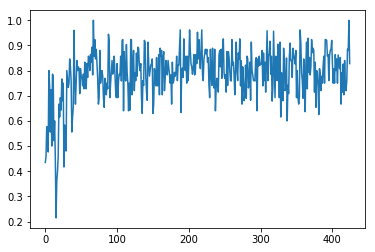

In [32]:
plt.plot(a)

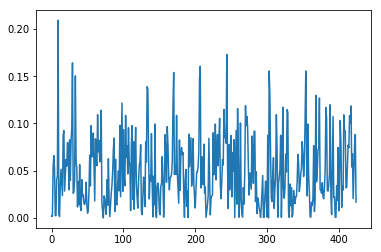

In [55]:
r =get_to_plot_regrets(rewards)
plt.plot(r)

In [33]:
all_steps  = []
for p in experiment.population.values():
    # if v['action'] and v['decision_time']
    all_steps.extend([v['tod'] for v in p.history.values()  if v['decision_time']])
print(all_steps.count(1))
print(all_steps.count(0))
print(all_steps.count(2))

8160
5440
0


In [32]:
#for participant,data in experiment.population.items():
#    print(len([h for h,v in data.history.items() if v['decision_time']]))

In [34]:
to_Save = make_to_save(experiment)

In [34]:
    filename = '{}/results/population_size_{}_update_days_{}_{}_static.pkl'.format('../../Downloads/pooling_results/batch/',pop_size,7,'short')
    with open(filename,'wb') as f:
        pickle.dump(to_Save,f)

##### all_steps  = [
]
for p in experiment.population.values():
    all_steps.extend([v['steps'] for v in p.history.values()])

In [33]:
def run_many():
    for case in ['case_one']:
    #case = 'case_one'
    #,'case_two','case_three'
        for u in [1]:
        
            all_actions = {}
            all_rewards = {}
            feat_trans = tf.feature_transformation('../../Downloads/distributions/')
            special = {}
            for sim in range(50):
                pop_size=32
                experiment = study.study('../../Downloads/distributions/',pop_size,'short',which_gen=case,sim_number=sim)
                glob,personal = initialize_policy_params_TS(experiment,u,standardize=False)
                hist = new_kind_of_simulation(experiment,'TS',personal,glob,tf=feat_trans)
                to_Save = make_to_save(experiment)
                actions,rewards,ractions = get_regret(experiment)
            
                for i,a in actions.items():
                    if i not in all_actions:
                        all_actions[i]=a
                    else:
                        all_actions[i].extend(a)
                for i,a in rewards.items():
                    if i not in all_rewards:
                        all_rewards[i]=a
                    else:
                        all_rewards[i].extend(a)
                special[sim]=actions

                filename = '{}/results/{}/population_size_{}_update_days_{}_{}_static_sim_{}_orignow_twotwo.pkl'.format('../../Downloads/pooling_results/batch/',case,pop_size,u,'short',sim)
                with open(filename,'wb') as f:
                    pickle.dump(to_Save,f)
            filename = '{}/results/{}/population_size_{}_update_days_{}_{}_static_sim_regrets_actions_l_twotwo_coeff.pkl'.format('../../Downloads/pooling_results/batch/',case,pop_size,u,'short')
            with open(filename,'wb') as f:
                pickle.dump({'actions':all_actions,'regrets':all_rewards},f)
            filename = '{}/results/{}/population_size_{}_update_days_{}_{}_action_percentonly_twotwo.pkl'.format('../../Downloads/pooling_results/batch/',case,pop_size,u,'short')
            with open(filename,'wb') as f:
                pickle.dump(special,f)

In [ ]:
run_many()

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15


In [20]:
[223.62212776908694,]

[223.62212776908694]

In [17]:
all_steps  = set([])
for p in experiment.population.values():
    all_steps.update([v['action'] for v in p.history.values()])
all_steps

{0, 1}

In [53]:
g = get_history(write_directory,1)

In [11]:
def create_phi_new(history_dict,pi,global_params):
    #these things will be accessed by the global params
    indices = ['weather','location']
    g0 = ['location']
    f1=['ltps']
    
    ##returns phi and psi indices
    ##this could be a bit faster not appending all the time
    all_data = []
    steps=[]
    for user_id,history in history_dict.items():
        #history = d.history
        #history_keys = sorted(history)
        for hk,h in history.items():
            
            h = history[hk]
            if h['decision_time']:
                v = [1]
                v.extend([h[i] for i in indices])
                v.append(pi*1)
                v.extend([pi*h[i] for i in f1])
                action = h['action']
                if action<0:
                    action=0
                
                v.append((action-pi)*1)
                v.extend([(action-pi)*h[i] for i in f1])
                v.append(action)
                v.append(float(user_id))
                v.append(float(h['study_day']))
                all_data.append(v)
                steps.append(h['steps'])
    return all_data,steps

In [55]:
p = create_phi_new(g,.6,glob)

In [12]:
def make_history_new(write_directory,pi,glob):
    g = get_history(write_directory,glob.decision_times)
    ad = create_phi_new(g,pi,glob)
    if len(ad[0])==0:
        return [[],[]]
    
    new_x = preprocessing.scale(np.array(ad[0]))
    new_y = preprocessing.scale(np.array(ad[1]))
    y = np.array([[float(r)] for r in new_y])
    X = new_x
    return [X,y]

In [49]:
np.array(gr[0][0]).mean()

446.51003316358634

In [7]:
np.array(means).mean()

137.29867338336618

In [38]:
gr[1][0]

[2, 0, 0, 0, 2, 1, 0, 1, 1]

In [13]:
get_today_variance(gr[0],gr[1],gr[2])

False


0.0

In [14]:
def get_all_day_slices(first,last):
    slices = []
    day = first
    
    while day<last:
        slice_one = [day]
        #slice_one.append(day.replace(hour=23,minute=30))
        
        day_two = day+pd.DateOffset(days=1)
        slice_one.append(day_two)
        slices.append(slice_one)
        day=day_two
    return slices

In [8]:
def transform_to_hour(steps):
    to_return = []
    for i in range(0,len(steps)-1,2):
        to_return.append(steps[i]+steps[i+1])
    return to_return

In [35]:
def day_slices_to_median(day_slices,day_lookup,all_steps):
    days_steps = []
    for ds in day_slices:
        steps = all_steps[day_lookup[ds[0]]:day_lookup[ds[1]]]
       
        steps = transform_to_hour(steps)
        print(len(steps))
        days_steps.append(np.array(steps).std())

    return np.median(np.array(days_steps))
        

In [19]:
x=get_all_day_slices(gr[3],gr[4])

In [43]:
gr[4]

Timestamp('2015-07-29 00:00:00', freq='30T')

In [13]:
[1]+[2]+[3,4]

[1, 2, 3, 4]

In [3]:
    last_index = dd[one_week_ago.date()][0]
    
    day_slices=get_all_day_slices(last_index,dd[i.date()][0])
    
    median = day_slices_to_median(day_slices,gr[2],gr[5])

You can pass in a bunch of decision times. I just tested with one. 

Right now I think the number of people is being totally ignored. This needs to be fixed. 

In [12]:
x=sim_functions.simulate_run(num_people,temp_indices,decision_times)

NameError: name 'temp_indices' is not defined

In [14]:
np.array(x).mean()
#np.array(x).std()

207.01370855122792

In [15]:
np.array(x).mean()
np.array(x).std()

267.8619020654599

In [ ]:
2-2-0-1-1-0-0-1

In [5]:
root =  '../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/temporary/'
data_root =  '../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/distributions/'


In [9]:
with open('../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/distributions/steps_both_groups_logs_dosage_estf.pkl'.format(),'rb') as f:
    df = pickle.load(f)

In [10]:
df.keys()

dict_keys(['2-0-2-1-2-1-0-3-18', '2-1-1-1-0-1-0-3-77', '2-0-0-0-3-3-0-3-9', '2-0-2-0-2-2-0-4-37', '2-1-2-1-0-1-0-4-70', '2-0-1-0-2-0-0-4-35', '2-1-2-1-0-1-0-3-13', '2-0-2-2-2-0-0-4-48', '2-0-1-1-2-1-0-3-28', '2-0-0-2-1-1-0-3-8', '2-0-2-0-2-0-0-3', '2-1-1-1-0-2-0-4-78', '2-0-1-1-2-1-0-3-31', '2-0-1-1-1-1-0-4-70', '2-0-1-2-1-3-0-4-66', '2-0-2-1-0-1-0-3-31', '2-0-1-2-0--1-0-4-25', '1-0-2-0-3-0-0-4-16', '2-1-2-0-3-2-0-4-3', '2-0-0-1-0-1-0-3', '2-1-1-1-1-1-0-3-18', '2-1-1-0-1-1-0-4-53', '2-1-2-2-1-1-0-4-35', '2-0-1-2-0--1-0-3-31', '2-0-1-2-0-3-0-4-64', '2-0-2-1-1-2-0', '1-1-1-0-3-3-0-3-38', '2-0-0-1-2-1-0-4-77', '2-0-2-2-1-1-1', '2-0-1-2-1-2-0', '2-0-2-2-0-2-1-3-3', '2-0-1-1-1-1-1-3-9', '1-0-2-0-0-0-0-4-94', '2-0-2-1-1-2-0-3-22', '2-0-1-2-0-0-1-4-9', '2-0-2-0-2-2-0-4-39', '2-1-1-1-2-0-0-4-91', '2-0-2-1-0-2-0-3-21', '2-0-1-0-0-0-0-4-38', '2-0-2-1-0-3-0-3-96', '2-0-2-0-0-1-1-4-1', '2-0-1-1-2-0-0-3-47', '2-0-1-1-1-2-0-4-9', '2-0-1-0-1-1-0-4-30', '2-0-1-1-0-2-0-3-53', '2-1-1-1-0-0-0-4-95', '2-1

In [37]:
6**.5

2.449489742783178

In [83]:
from scipy.stats import norm
norm.cdf((2.2)/(19**.5))

0.6931203525811124